# Session 4.2: Time Series Analysis

**Durasi:** 60 menit  
**Dataset:** RUP 2025

## Tujuan Pembelajaran
- DateTime operations dan indexing
- Resampling data temporal
- Rolling windows dan moving averages
- Trend analysis (MoM, YoY)
- Seasonality detection
- Time series visualization

## 1. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Try to import statsmodels for decomposition
try:
    from statsmodels.tsa.seasonal import seasonal_decompose
    HAS_STATSMODELS = True
except ImportError:
    HAS_STATSMODELS = False
    print("⚠️ statsmodels not installed. Install with: pip install statsmodels")

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 2. Load Dataset

In [3]:
# Load data
data_path = Path('../../../datasets/rup/RUP-PaketPenyedia-Terumumkan-2025.parquet')
df = pd.read_parquet(data_path)

print(f"Dataset shape: {df.shape}")
print(f"\nColumns with 'tanggal' or 'date':")
date_cols = [col for col in df.columns if 'tanggal' in col.lower() or 'date' in col.lower()]
for col in date_cols:
    print(f"  - {col}")

df.head()

Dataset shape: (16430, 48)

Columns with 'tanggal' or 'date':
  - _event_date


,tahun_anggaran,kd_klpd,nama_klpd,jenis_klpd,kd_satker,kd_satker_str,nama_satker,kd_rup,nama_paket,pagu,...,status_umumkan_rup,status_dikecualikan,alasan_dikecualikan,tahun_pertama,kode_rup_tahun_pertama,nomor_kontrak,spp_aspek_ekonomi,spp_aspek_sosial,spp_aspek_lingkungan,_event_date
0,2025,D197,Provinsi Kalimantan Barat,PROVINSI,264455,1.02.0.00.0.00.03.0000,RUMAH SAKIT JIWA PROVINSI KALIMANTAN BARAT,53540979,Belanja Bahan Makanan dan Minuman Pasien,7700000000,...,Terumumkan,False,,None,None,None,False,False,False,2025-11-05
1,2025,D197,Provinsi Kalimantan Barat,PROVINSI,264456,1.03.0.00.0.00.01.0000,DINAS PEKERJAAN UMUM DAN PENATAAN RUANG PROVIN...,53688068,Perencanaan Rehabilitasi Gedung UPT Pengujian ...,300000000,...,Terumumkan,False,None,None,None,None,False,False,False,2025-11-05
2,2025,D197,Provinsi Kalimantan Barat,PROVINSI,264456,1.03.0.00.0.00.01.0000,DINAS PEKERJAAN UMUM DAN PENATAAN RUANG PROVIN...,53699505,PENGAWASAN TEKNIS PENGGANTIAN/PEMBANGUNAN JEMB...,1200000000,...,Terumumkan,False,None,None,None,None,True,True,True,2025-11-05
3,2025,D197,Provinsi Kalimantan Barat,PROVINSI,264456,1.03.0.00.0.00.01.0000,DINAS PEKERJAAN UMUM DAN PENATAAN RUANG PROVIN...,53700150,PENGAWASAN TEKNIS PENINGKATAN JALAN TANJUNG M...,1200000000,...,Terumumkan,False,None,None,None,None,True,True,True,2025-11-05
4,2025,D197,Provinsi Kalimantan Barat,PROVINSI,264456,1.03.0.00.0.00.01.0000,DINAS PEKERJAAN UMUM DAN PENATAAN RUANG PROVIN...,53700183,PENGAWASAN TEKNIS PENINGKATAN JALAN MARAU AIR...,1500000000,...,Terumumkan,False,None,None,None,None,True,True,True,2025-11-05


## 3. DateTime Operations

### 3.1 Parse Dates

In [5]:
# Find date column
date_col = None
for col in ['tgl_buat_paket', 'tgl_pengumuman', 'created_at']:
    if col in df.columns:
        date_col = col
        break

if date_col:
    # Convert to datetime
    df['date'] = pd.to_datetime(df[date_col], errors='coerce')
    
    print(f"Using column: {date_col}")
    print(f"Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"Total days: {(df['date'].max() - df['date'].min()).days}")
    print(f"Valid dates: {df['date'].notna().sum()} / {len(df)}")
    
    # Remove rows with invalid dates
    df_ts = df[df['date'].notna()].copy()
    print(f"\nDataset after removing invalid dates: {df_ts.shape}")
else:
    print("⚠️ No date column found. Creating sample dates for demonstration.")
    # Create sample dates
    df_ts = df.copy()
    df_ts['date'] = pd.date_range(start='2024-01-01', periods=len(df), freq='H')

Using column: tgl_buat_paket
Date range: 2024-11-22 00:00:00 to 2025-11-04 00:00:00
Total days: 347
Valid dates: 16430 / 16430

Dataset after removing invalid dates: (16430, 49)


### 3.2 Extract Date Components

In [6]:
# Extract date features
df_ts['year'] = df_ts['date'].dt.year
df_ts['month'] = df_ts['date'].dt.month
df_ts['month_name'] = df_ts['date'].dt.month_name()
df_ts['quarter'] = df_ts['date'].dt.quarter
df_ts['day'] = df_ts['date'].dt.day
df_ts['day_of_week'] = df_ts['date'].dt.dayofweek
df_ts['day_name'] = df_ts['date'].dt.day_name()
df_ts['week_of_year'] = df_ts['date'].dt.isocalendar().week

print("Date Components Extracted:")
print(df_ts[['date', 'year', 'month', 'month_name', 'quarter', 'day', 'day_name']].head(10))

Date Components Extracted:
        date  year  month month_name  quarter  day  day_name
0 2024-11-22  2024     11   November        4   22    Friday
1 2024-12-09  2024     12   December        4    9    Monday
2 2024-12-10  2024     12   December        4   10   Tuesday
3 2024-12-10  2024     12   December        4   10   Tuesday
4 2024-12-10  2024     12   December        4   10   Tuesday
5 2024-12-14  2024     12   December        4   14  Saturday
6 2024-12-14  2024     12   December        4   14  Saturday
7 2024-12-14  2024     12   December        4   14  Saturday
8 2024-12-14  2024     12   December        4   14  Saturday
9 2024-12-14  2024     12   December        4   14  Saturday


### 3.3 DateTime Indexing

In [7]:
# Set date as index
df_indexed = df_ts.set_index('date').sort_index()

print("DataFrame with DateTime Index:")
print(df_indexed.head())
print(f"\nIndex type: {type(df_indexed.index)}")
print(f"Index range: {df_indexed.index.min()} to {df_indexed.index.max()}")

DataFrame with DateTime Index:
            tahun_anggaran kd_klpd                  nama_klpd jenis_klpd  \
date                                                                       
2024-11-22            2025    D197  Provinsi Kalimantan Barat   PROVINSI   
2024-12-09            2025    D197  Provinsi Kalimantan Barat   PROVINSI   
2024-12-10            2025    D197  Provinsi Kalimantan Barat   PROVINSI   
2024-12-10            2025    D197  Provinsi Kalimantan Barat   PROVINSI   
2024-12-10            2025    D197  Provinsi Kalimantan Barat   PROVINSI   

            kd_satker           kd_satker_str  \
date                                            
2024-11-22     264455  1.02.0.00.0.00.03.0000   
2024-12-09     264456  1.03.0.00.0.00.01.0000   
2024-12-10     264456  1.03.0.00.0.00.01.0000   
2024-12-10     264456  1.03.0.00.0.00.01.0000   
2024-12-10     264456  1.03.0.00.0.00.01.0000   

                                                  nama_satker    kd_rup  \
date             

## 4. Resampling

### 4.1 Daily Aggregation

In [8]:
# Daily count of packages
daily_count = df_indexed.resample('D').size()

# Daily sum of pagu (if exists)
if 'pagu' in df_indexed.columns:
    daily_pagu = df_indexed['pagu'].resample('D').sum() / 1_000_000_000  # in billions
    daily_stats = pd.DataFrame({
        'count': daily_count,
        'total_pagu_miliar': daily_pagu,
        'avg_pagu_juta': (df_indexed['pagu'].resample('D').mean() / 1_000_000)
    })
else:
    daily_stats = pd.DataFrame({'count': daily_count})

print("Daily Statistics:")
print(daily_stats.head(10))
print(f"\nTotal days with activity: {(daily_stats['count'] > 0).sum()}")

Daily Statistics:
            count  total_pagu_miliar  avg_pagu_juta
date                                               
2024-11-22      1                7.7         7700.0
2024-11-23      0                0.0            NaN
2024-11-24      0                0.0            NaN
2024-11-25      0                0.0            NaN
2024-11-26      0                0.0            NaN
2024-11-27      0                0.0            NaN
2024-11-28      0                0.0            NaN
2024-11-29      0                0.0            NaN
2024-11-30      0                0.0            NaN
2024-12-01      0                0.0            NaN

Total days with activity: 248


### 4.2 Weekly, Monthly, Quarterly Aggregation

In [9]:
# Weekly aggregation
weekly = df_indexed.resample('W').agg({
    'kd_rup': 'count'
})
weekly.columns = ['weekly_count']

# Monthly aggregation
monthly = df_indexed.resample('M').agg({
    'kd_rup': 'count'
})
monthly.columns = ['monthly_count']

# Quarterly aggregation
quarterly = df_indexed.resample('Q').agg({
    'kd_rup': 'count'
})
quarterly.columns = ['quarterly_count']

print("Weekly Aggregation:")
print(weekly.head())
print("\nMonthly Aggregation:")
print(monthly.head())
print("\nQuarterly Aggregation:")
print(quarterly.head())

Weekly Aggregation:
            weekly_count
date                    
2024-11-24             1
2024-12-01             0
2024-12-08             0
2024-12-15           107
2024-12-22           378

Monthly Aggregation:
            monthly_count
date                     
2024-11-30              1
2024-12-31            703
2025-01-31           2971
2025-02-28           2390
2025-03-31           3570

Quarterly Aggregation:
            quarterly_count
date                       
2024-12-31              704
2025-03-31             8931
2025-06-30             3451
2025-09-30              917
2025-12-31             2427


### 4.3 Visualize Different Time Granularities

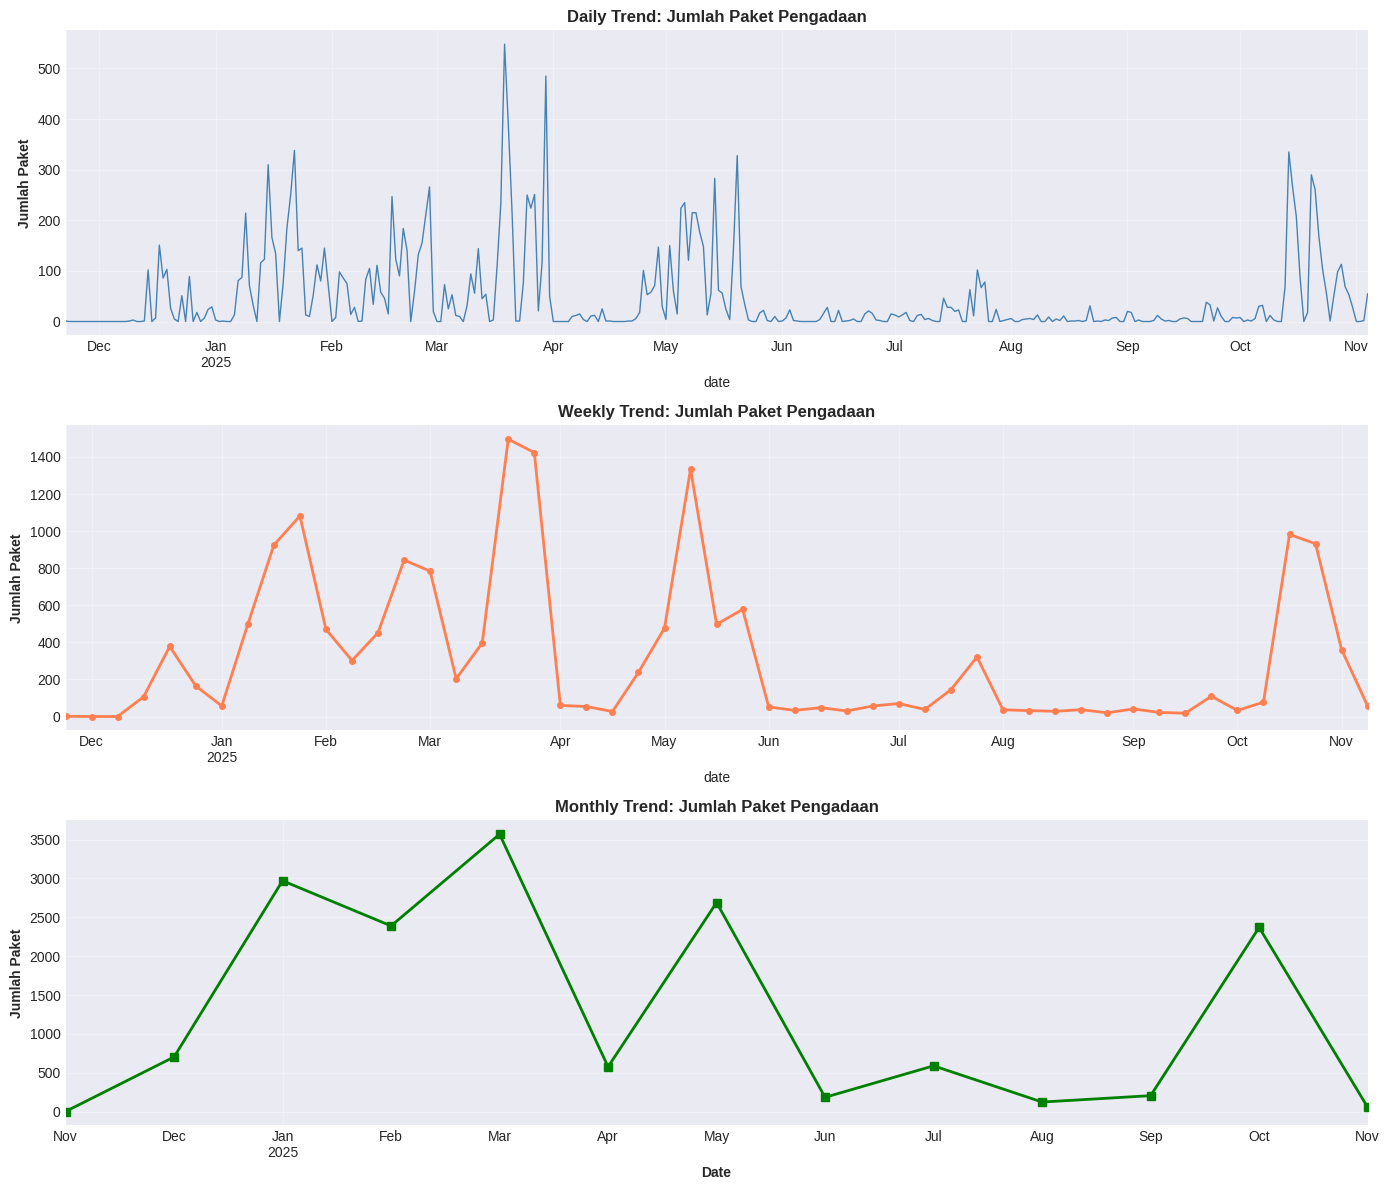

In [10]:
# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Daily
daily_stats['count'].plot(ax=axes[0], color='steelblue', linewidth=1)
axes[0].set_title('Daily Trend: Jumlah Paket Pengadaan', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Jumlah Paket', fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Weekly
weekly['weekly_count'].plot(ax=axes[1], color='coral', linewidth=2, marker='o', markersize=4)
axes[1].set_title('Weekly Trend: Jumlah Paket Pengadaan', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Jumlah Paket', fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Monthly
monthly['monthly_count'].plot(ax=axes[2], color='green', linewidth=2, marker='s', markersize=6)
axes[2].set_title('Monthly Trend: Jumlah Paket Pengadaan', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Jumlah Paket', fontweight='bold')
axes[2].set_xlabel('Date', fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Rolling Windows & Moving Averages

### 5.1 Simple Moving Average (SMA)

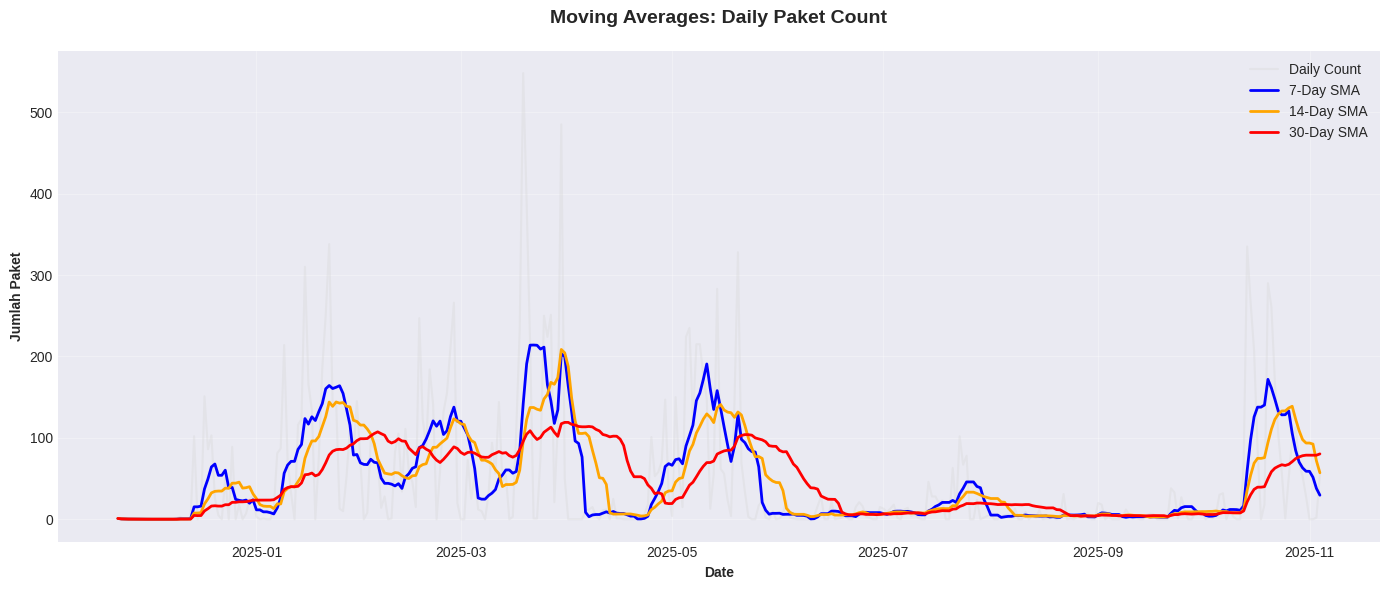

Moving Averages:
            count       SMA_7      SMA_14     SMA_30
date                                                
2025-10-26     51  133.142857  136.714286  67.466667
2025-10-27     98  105.714286  138.785714  70.733333
2025-10-28    113   84.571429  122.928571  74.500000
2025-10-29     69   70.285714  108.857143  76.533333
2025-10-30     53   63.142857   97.857143  78.066667
2025-10-31     28   59.000000   93.642857  78.733333
2025-11-01      0   58.857143   93.642857  78.733333
2025-11-02      0   51.571429   92.357143  78.633333
2025-11-03      2   37.857143   71.785714  78.666667
2025-11-04     55   29.571429   57.071429  80.300000


In [11]:
# Calculate rolling averages
daily_stats['SMA_7'] = daily_stats['count'].rolling(window=7, min_periods=1).mean()
daily_stats['SMA_14'] = daily_stats['count'].rolling(window=14, min_periods=1).mean()
daily_stats['SMA_30'] = daily_stats['count'].rolling(window=30, min_periods=1).mean()

# Visualize
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(daily_stats.index, daily_stats['count'], label='Daily Count', alpha=0.3, color='lightgray')
ax.plot(daily_stats.index, daily_stats['SMA_7'], label='7-Day SMA', linewidth=2, color='blue')
ax.plot(daily_stats.index, daily_stats['SMA_14'], label='14-Day SMA', linewidth=2, color='orange')
ax.plot(daily_stats.index, daily_stats['SMA_30'], label='30-Day SMA', linewidth=2, color='red')

ax.set_title('Moving Averages: Daily Paket Count', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Date', fontweight='bold')
ax.set_ylabel('Jumlah Paket', fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Moving Averages:")
print(daily_stats[['count', 'SMA_7', 'SMA_14', 'SMA_30']].tail(10))

### 5.2 Exponential Moving Average (EMA)

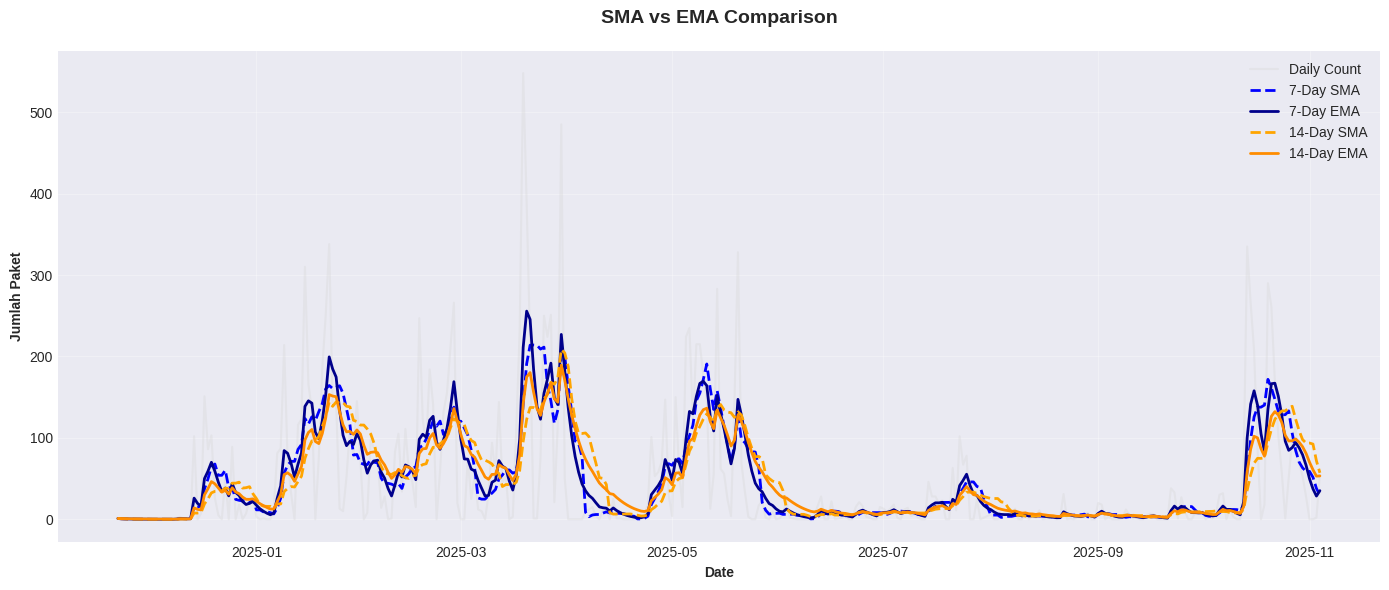

In [12]:
# Calculate exponential moving averages
daily_stats['EMA_7'] = daily_stats['count'].ewm(span=7, adjust=False).mean()
daily_stats['EMA_14'] = daily_stats['count'].ewm(span=14, adjust=False).mean()

# Compare SMA vs EMA
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(daily_stats.index, daily_stats['count'], label='Daily Count', alpha=0.3, color='lightgray')
ax.plot(daily_stats.index, daily_stats['SMA_7'], label='7-Day SMA', linewidth=2, linestyle='--', color='blue')
ax.plot(daily_stats.index, daily_stats['EMA_7'], label='7-Day EMA', linewidth=2, color='darkblue')
ax.plot(daily_stats.index, daily_stats['SMA_14'], label='14-Day SMA', linewidth=2, linestyle='--', color='orange')
ax.plot(daily_stats.index, daily_stats['EMA_14'], label='14-Day EMA', linewidth=2, color='darkorange')

ax.set_title('SMA vs EMA Comparison', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Date', fontweight='bold')
ax.set_ylabel('Jumlah Paket', fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 5.3 Rolling Sum & Other Statistics

In [13]:
# Rolling statistics
daily_stats['rolling_sum_7'] = daily_stats['count'].rolling(window=7).sum()
daily_stats['rolling_std_7'] = daily_stats['count'].rolling(window=7).std()
daily_stats['rolling_min_7'] = daily_stats['count'].rolling(window=7).min()
daily_stats['rolling_max_7'] = daily_stats['count'].rolling(window=7).max()

print("Rolling Statistics (7-day window):")
print(daily_stats[['count', 'rolling_sum_7', 'rolling_std_7', 'rolling_min_7', 'rolling_max_7']].tail(10))

Rolling Statistics (7-day window):
            count  rolling_sum_7  rolling_std_7  rolling_min_7  rolling_max_7
date                                                                         
2025-10-26     51          932.0     110.418037            1.0          290.0
2025-10-27     98          740.0      86.136934            1.0          261.0
2025-10-28    113          592.0      53.739672            1.0          169.0
2025-10-29     69          492.0      38.758716            1.0          113.0
2025-10-30     53          442.0      36.251108            1.0          113.0
2025-10-31     28          413.0      38.647984            1.0          113.0
2025-11-01      0          412.0      38.899137            0.0          113.0
2025-11-02      0          361.0      44.925335            0.0          113.0
2025-11-03      2          265.0      43.001661            0.0          113.0
2025-11-04     55          207.0      29.613382            0.0           69.0


## 6. Cumulative Calculations

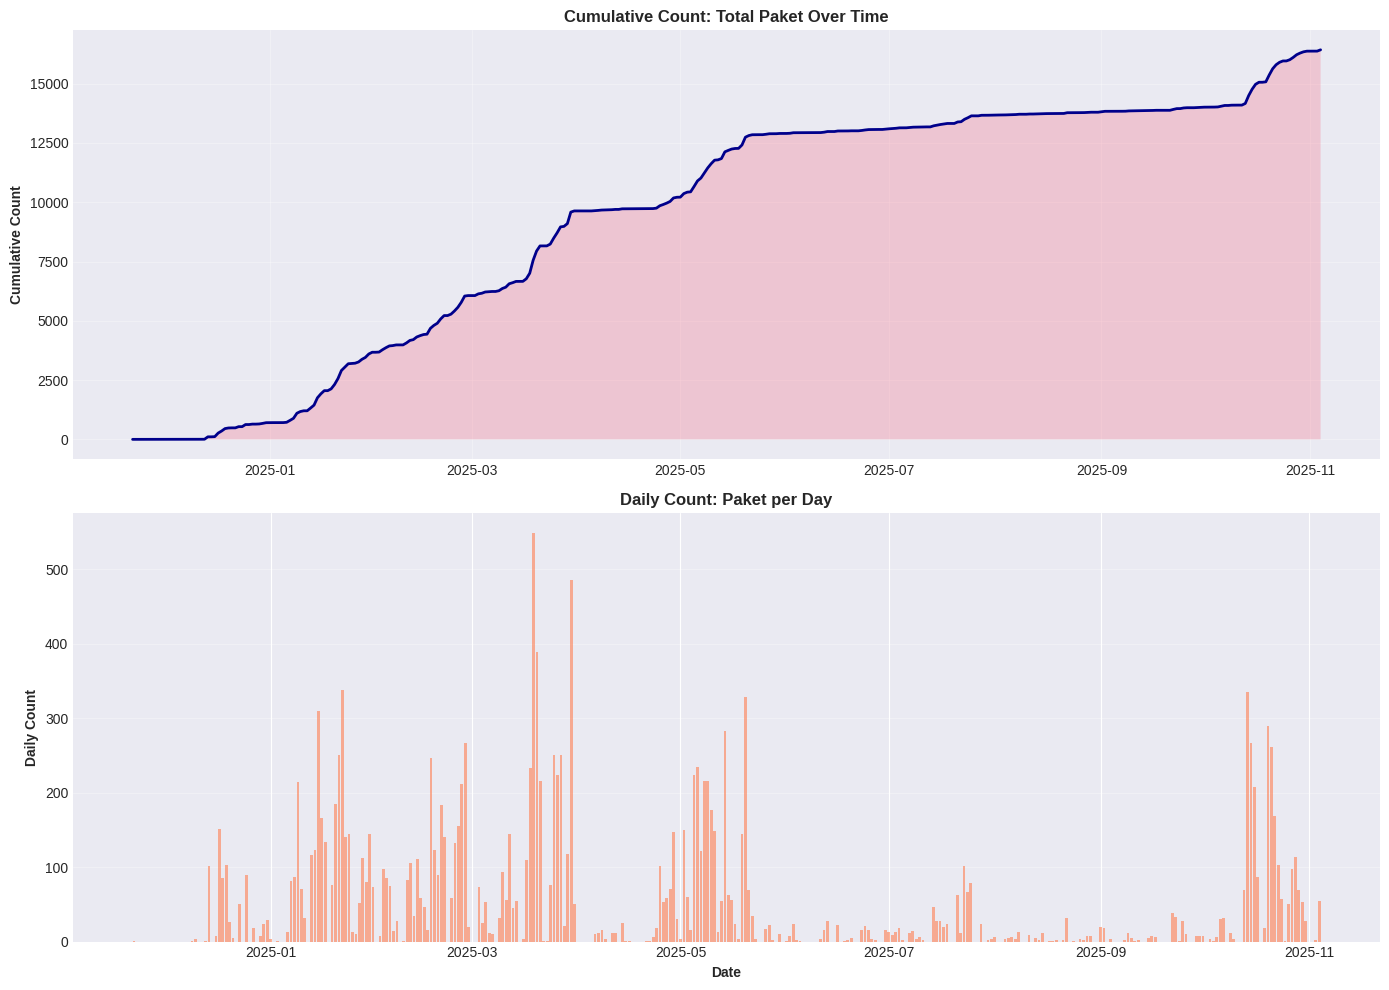

Total cumulative packages: 16,430


In [14]:
# Cumulative sum
daily_stats['cumulative_count'] = daily_stats['count'].cumsum()

if 'total_pagu_miliar' in daily_stats.columns:
    daily_stats['cumulative_pagu'] = daily_stats['total_pagu_miliar'].cumsum()

# Visualize
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Cumulative count
axes[0].plot(daily_stats.index, daily_stats['cumulative_count'], linewidth=2, color='darkblue')
axes[0].fill_between(daily_stats.index, daily_stats['cumulative_count'], alpha=0.3)
axes[0].set_title('Cumulative Count: Total Paket Over Time', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Cumulative Count', fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Daily count for comparison
axes[1].bar(daily_stats.index, daily_stats['count'], alpha=0.6, color='coral')
axes[1].set_title('Daily Count: Paket per Day', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Date', fontweight='bold')
axes[1].set_ylabel('Daily Count', fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"Total cumulative packages: {daily_stats['cumulative_count'].iloc[-1]:,.0f}")

## 7. Trend Analysis

### 7.1 Period-over-Period Growth

Monthly Growth Rates:
            monthly_count  MoM_change      MoM_pct
date                                              
2025-02-28           2390      -581.0   -19.555705
2025-03-31           3570      1180.0    49.372385
2025-04-30            577     -2993.0   -83.837535
2025-05-31           2690      2113.0   366.204506
2025-06-30            184     -2506.0   -93.159851
2025-07-31            589       405.0   220.108696
2025-08-31            123      -466.0   -79.117148
2025-09-30            205        82.0    66.666667
2025-10-31           2370      2165.0  1056.097561
2025-11-30             57     -2313.0   -97.594937


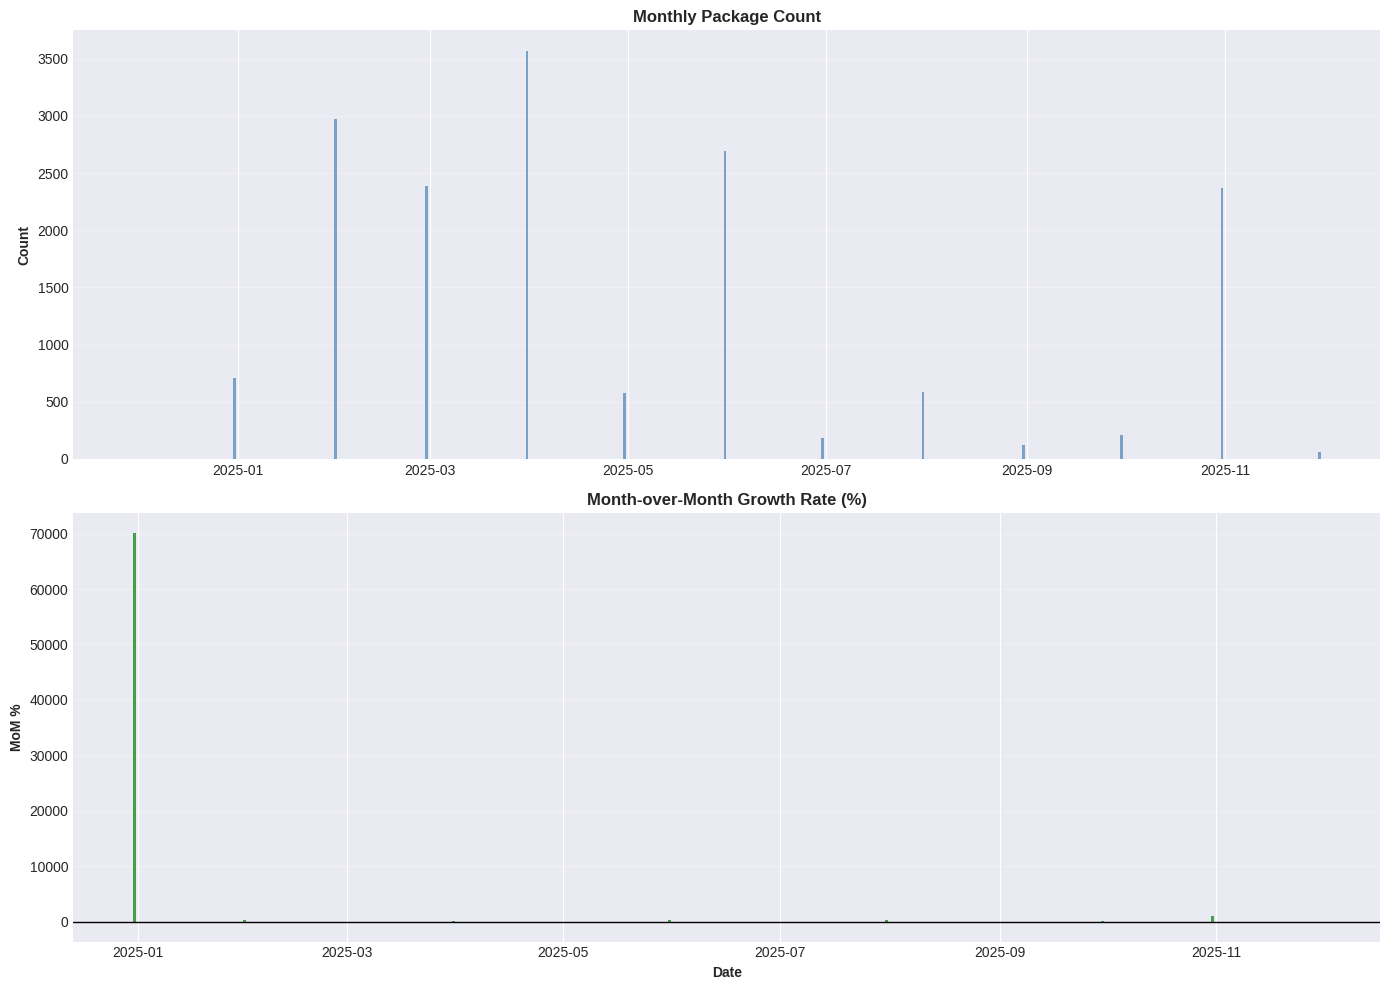

In [15]:
# Day-over-Day (DoD) change
daily_stats['DoD_change'] = daily_stats['count'].diff()
daily_stats['DoD_pct'] = daily_stats['count'].pct_change() * 100

# Week-over-Week (WoW) for weekly data
weekly['WoW_change'] = weekly['weekly_count'].diff()
weekly['WoW_pct'] = weekly['weekly_count'].pct_change() * 100

# Month-over-Month (MoM) for monthly data
monthly['MoM_change'] = monthly['monthly_count'].diff()
monthly['MoM_pct'] = monthly['monthly_count'].pct_change() * 100

print("Monthly Growth Rates:")
print(monthly[['monthly_count', 'MoM_change', 'MoM_pct']].tail(10))

# Visualize MoM growth
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Monthly count
axes[0].bar(monthly.index, monthly['monthly_count'], color='steelblue', alpha=0.7)
axes[0].set_title('Monthly Package Count', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count', fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# MoM % change
colors = ['green' if x > 0 else 'red' for x in monthly['MoM_pct']]
axes[1].bar(monthly.index, monthly['MoM_pct'], color=colors, alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1].set_title('Month-over-Month Growth Rate (%)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Date', fontweight='bold')
axes[1].set_ylabel('MoM %', fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### 7.2 Year-over-Year (YoY) Comparison

Year-over-Year Comparison:
      count  YoY_change      YoY_pct
year                                
2024    704         NaN          NaN
2025  15726     15022.0  2133.806818


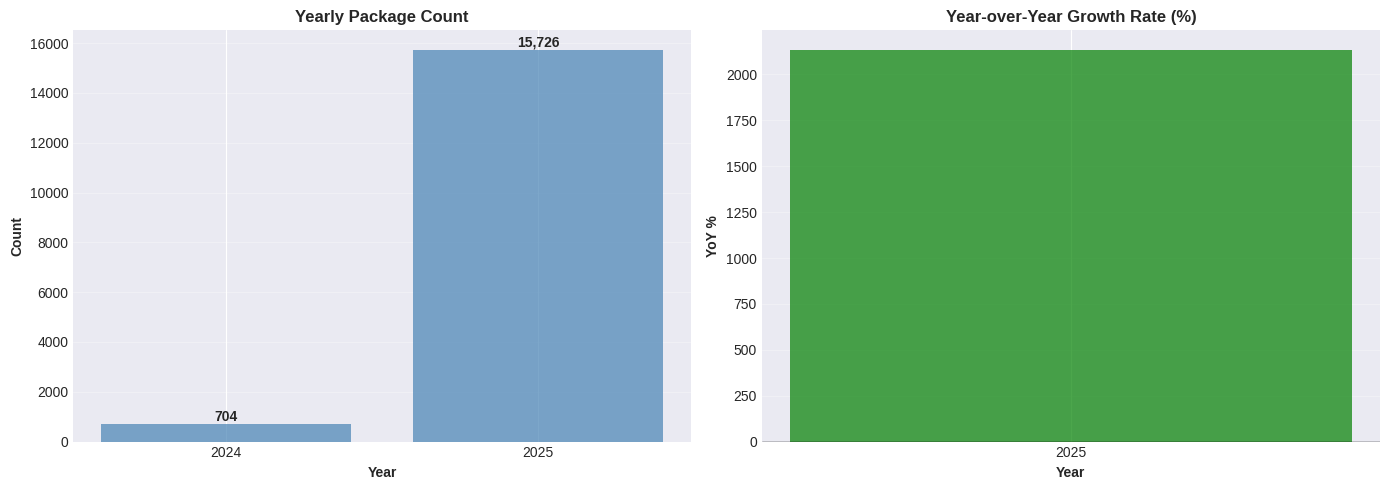

In [16]:
# YoY comparison (if we have multiple years)
if 'year' in df_ts.columns:
    yearly = df_ts.groupby('year').size().to_frame('count')
    yearly['YoY_change'] = yearly['count'].diff()
    yearly['YoY_pct'] = yearly['count'].pct_change() * 100
    
    print("Year-over-Year Comparison:")
    print(yearly)
    
    if len(yearly) > 1:
        # Visualize
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        axes[0].bar(yearly.index.astype(str), yearly['count'], color='steelblue', alpha=0.7)
        axes[0].set_title('Yearly Package Count', fontsize=12, fontweight='bold')
        axes[0].set_ylabel('Count', fontweight='bold')
        axes[0].set_xlabel('Year', fontweight='bold')
        axes[0].grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for i, (year, count) in enumerate(zip(yearly.index, yearly['count'])):
            axes[0].text(i, count, f'{count:,.0f}', ha='center', va='bottom', fontweight='bold')
        
        # YoY growth
        axes[1].bar(yearly.index[1:].astype(str), yearly['YoY_pct'].iloc[1:], 
                   color=['green' if x > 0 else 'red' for x in yearly['YoY_pct'].iloc[1:]], alpha=0.7)
        axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
        axes[1].set_title('Year-over-Year Growth Rate (%)', fontsize=12, fontweight='bold')
        axes[1].set_ylabel('YoY %', fontweight='bold')
        axes[1].set_xlabel('Year', fontweight='bold')
        axes[1].grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()
else:
    print("Year column not available for YoY analysis")

## 8. Seasonality Analysis

### 8.1 Monthly Patterns

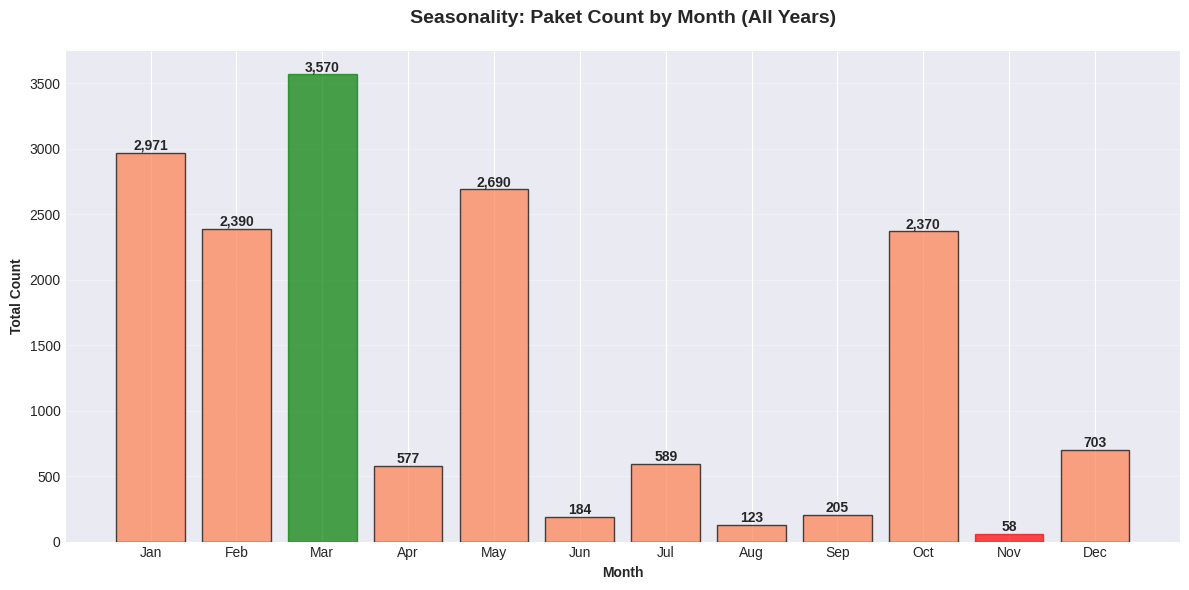


Monthly Pattern:
Jan: 2,971
Feb: 2,390
Mar: 3,570
Apr: 577
May: 2,690
Jun: 184
Jul: 589
Aug: 123
Sep: 205
Oct: 2,370
Nov: 58
Dec: 703


In [17]:
# Aggregate by month (across all years)
if 'month' in df_ts.columns:
    monthly_pattern = df_ts.groupby('month').size()
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(month_names, monthly_pattern.values, color='coral', edgecolor='black', alpha=0.7)
    
    # Highlight max and min
    max_idx = monthly_pattern.values.argmax()
    min_idx = monthly_pattern.values.argmin()
    bars[max_idx].set_color('green')
    bars[min_idx].set_color('red')
    
    ax.set_title('Seasonality: Paket Count by Month (All Years)', fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Month', fontweight='bold')
    ax.set_ylabel('Total Count', fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, (month, count) in enumerate(zip(month_names, monthly_pattern.values)):
        ax.text(i, count, f'{count:,.0f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("\nMonthly Pattern:")
    for month, count in zip(month_names, monthly_pattern.values):
        print(f"{month}: {count:,}")

### 8.2 Day of Week Patterns

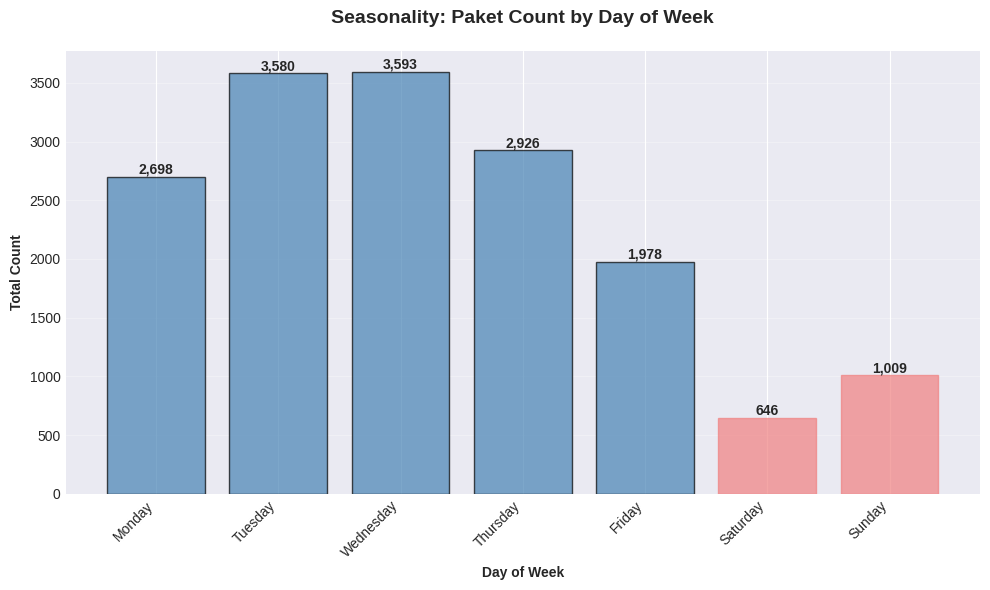

In [18]:
# Aggregate by day of week
if 'day_of_week' in df_ts.columns:
    dow_pattern = df_ts.groupby('day_of_week').size()
    dow_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(dow_names, dow_pattern.values, color='steelblue', edgecolor='black', alpha=0.7)
    
    # Highlight weekends
    bars[5].set_color('lightcoral')  # Saturday
    bars[6].set_color('lightcoral')  # Sunday
    
    ax.set_title('Seasonality: Paket Count by Day of Week', fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Day of Week', fontweight='bold')
    ax.set_ylabel('Total Count', fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    plt.xticks(rotation=45, ha='right')
    
    # Add value labels
    for i, (day, count) in enumerate(zip(dow_names, dow_pattern.values)):
        ax.text(i, count, f'{count:,.0f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

### 8.3 Seasonal Decomposition (if statsmodels available)

In [19]:
if HAS_STATSMODELS and len(monthly) >= 24:  # Need at least 2 years of monthly data
    # Perform seasonal decomposition
    decomposition = seasonal_decompose(monthly['monthly_count'], model='additive', period=12)
    
    # Plot components
    fig, axes = plt.subplots(4, 1, figsize=(14, 12))
    
    # Original
    decomposition.observed.plot(ax=axes[0], color='blue')
    axes[0].set_title('Original Time Series', fontweight='bold')
    axes[0].set_ylabel('Count', fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Trend
    decomposition.trend.plot(ax=axes[1], color='red')
    axes[1].set_title('Trend Component', fontweight='bold')
    axes[1].set_ylabel('Trend', fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    # Seasonal
    decomposition.seasonal.plot(ax=axes[2], color='green')
    axes[2].set_title('Seasonal Component', fontweight='bold')
    axes[2].set_ylabel('Seasonal', fontweight='bold')
    axes[2].grid(True, alpha=0.3)
    
    # Residual
    decomposition.resid.plot(ax=axes[3], color='purple')
    axes[3].set_title('Residual Component', fontweight='bold')
    axes[3].set_ylabel('Residual', fontweight='bold')
    axes[3].set_xlabel('Date', fontweight='bold')
    axes[3].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    if not HAS_STATSMODELS:
        print("⚠️ Statsmodels not available. Install with: pip install statsmodels")
    else:
        print("⚠️ Not enough data for seasonal decomposition (need at least 24 months)")

⚠️ Not enough data for seasonal decomposition (need at least 24 months)


## 9. Summary Statistics by Time Period

In [20]:
print("=" * 70)
print("TIME SERIES ANALYSIS SUMMARY")
print("=" * 70)

print(f"\n1. DATE RANGE")
print(f"   Start: {df_ts['date'].min()}")
print(f"   End: {df_ts['date'].max()}")
print(f"   Total Days: {(df_ts['date'].max() - df_ts['date'].min()).days}")

print(f"\n2. DAILY STATISTICS")
print(f"   Average daily count: {daily_stats['count'].mean():.2f}")
print(f"   Max daily count: {daily_stats['count'].max():.0f}")
print(f"   Min daily count: {daily_stats['count'].min():.0f}")
print(f"   Std deviation: {daily_stats['count'].std():.2f}")

print(f"\n3. TRENDS")
print(f"   Average MoM growth: {monthly['MoM_pct'].mean():.2f}%")
print(f"   Max MoM growth: {monthly['MoM_pct'].max():.2f}%")
print(f"   Min MoM growth: {monthly['MoM_pct'].min():.2f}%")

if 'month' in df_ts.columns:
    peak_month = monthly_pattern.idxmax()
    low_month = monthly_pattern.idxmin()
    print(f"\n4. SEASONALITY")
    print(f"   Peak month: {month_names[peak_month-1]} ({monthly_pattern[peak_month]:,} paket)")
    print(f"   Lowest month: {month_names[low_month-1]} ({monthly_pattern[low_month]:,} paket)")

print("\n" + "=" * 70)

TIME SERIES ANALYSIS SUMMARY

1. DATE RANGE
   Start: 2024-11-22 00:00:00
   End: 2025-11-04 00:00:00
   Total Days: 347

2. DAILY STATISTICS
   Average daily count: 47.21
   Max daily count: 548
   Min daily count: 0
   Std deviation: 81.62

3. TRENDS
   Average MoM growth: 5992.32%
   Max MoM growth: 70200.00%
   Min MoM growth: -97.59%

4. SEASONALITY
   Peak month: Mar (3,570 paket)
   Lowest month: Nov (58 paket)



## 10. Key Takeaways

### DateTime Operations:
- ✅ Parse dates dengan `pd.to_datetime()`
- ✅ Extract components: year, month, day, etc.
- ✅ Set DateTime index untuk time series analysis

### Resampling:
- ✅ Daily, Weekly, Monthly, Quarterly aggregation
- ✅ Different aggregation functions (count, sum, mean)

### Rolling Windows:
- ✅ Simple Moving Average (SMA)
- ✅ Exponential Moving Average (EMA)
- ✅ Rolling statistics (sum, std, min, max)

### Trend Analysis:
- ✅ Day-over-Day, Week-over-Week, Month-over-Month
- ✅ Year-over-Year comparisons
- ✅ Growth rate calculations

### Seasonality:
- ✅ Monthly patterns
- ✅ Day of week patterns
- ✅ Seasonal decomposition